2025-07-15 05:56:14.237837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752558974.460330      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752558974.523369      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



📊 Combo 1 → Train:Test = 10:90


I0000 00:00:1752558988.457709      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752558988.458395      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


 Epoch 1/20, Loss: 4.3131
 Epoch 2/20, Loss: 4.2757
 Epoch 3/20, Loss: 4.2800
 Epoch 4/20, Loss: 4.2040
 Epoch 5/20, Loss: 4.1875
 Epoch 6/20, Loss: 4.1658
 Epoch 7/20, Loss: 4.1596
 Epoch 8/20, Loss: 4.1722
 Epoch 9/20, Loss: 4.1967
 Epoch 10/20, Loss: 4.1573
 Epoch 11/20, Loss: 4.1643
 Epoch 12/20, Loss: 4.1162
 Epoch 13/20, Loss: 4.1713
 Epoch 14/20, Loss: 4.1306
 Epoch 15/20, Loss: 4.1294
 Epoch 16/20, Loss: 4.1392
 Epoch 17/20, Loss: 4.1517
 Epoch 18/20, Loss: 4.1156
 Epoch 19/20, Loss: 4.1261
 Epoch 20/20, Loss: 4.1231


I0000 00:00:1752559023.815775     105 service.cc:148] XLA service 0x7a284c02a7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752559023.816451     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752559023.816485     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752559023.887186     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


134/806 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1752559024.105286     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


806/806 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
✅ Linear Regression Accuracy = 0.8971, F1 Class 0 = 0.8450, F1 Class 1 = 0.9230

📊 Combo 2 → Train:Test = 20:80
 Epoch 1/20, Loss: 4.9491
 Epoch 2/20, Loss: 4.9198
 Epoch 3/20, Loss: 4.8660
 Epoch 4/20, Loss: 4.8458
 Epoch 5/20, Loss: 4.8602
 Epoch 6/20, Loss: 4.8252
 Epoch 7/20, Loss: 4.8274
 Epoch 8/20, Loss: 4.8337
 Epoch 9/20, Loss: 4.8162
 Epoch 10/20, Loss: 4.7972
 Epoch 11/20, Loss: 4.8092
 Epoch 12/20, Loss: 4.8123
 Epoch 13/20, Loss: 4.7974
 Epoch 14/20, Loss: 4.7849
 Epoch 15/20, Loss: 4.7869
 Epoch 16/20, Loss: 4.7949
 Epoch 17/20, Loss: 4.8033
 Epoch 18/20, Loss: 4.8109
 Epoch 19/20, Loss: 4.7913
 Epoch 20/20, Loss: 4.7849
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
✅ Linear Regression Accuracy = 0.9002, F1 Class 0 = 0.8491, F1 Class 1 = 0.9255

📊 Combo 3 → Train:Test = 30:70
 Epoch 1/20, Loss: 5.3229
 Epoch 2/20, Loss: 5.3029
 Epoch 3/20, Loss: 5.27

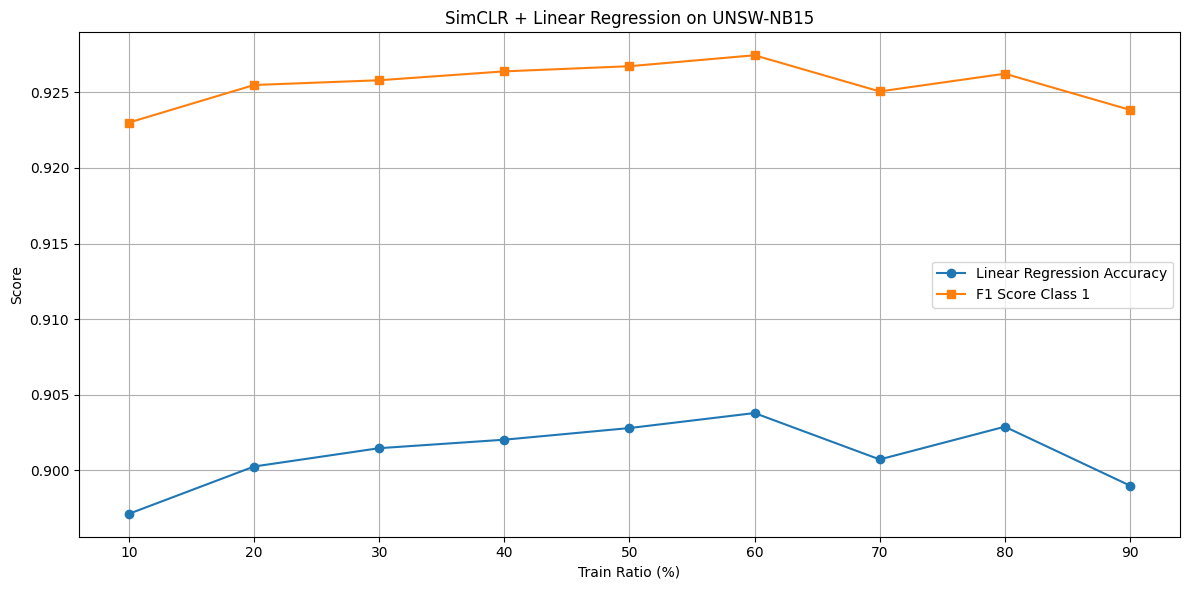

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset
train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])

# Preprocess
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')
for col in ['proto', 'service', 'state']:
    df[col] = pd.factorize(df[col])[0]
X = df.drop('label', axis=1)
y = df['label']
X = StandardScaler().fit_transform(X)

# Encoder
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.Dense(256, activation='relu')(x)
    return models.Model(inputs, x)

# Projection Head
def build_projection_head(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64)(x)
    return models.Model(inputs, x)

# NT-Xent loss
def nt_xent_loss(z_i, z_j, temperature=0.5):
    z_i = tf.math.l2_normalize(z_i, axis=1)
    z_j = tf.math.l2_normalize(z_j, axis=1)
    representations = tf.concat([z_i, z_j], axis=0)
    similarity_matrix = tf.matmul(representations, representations, transpose_b=True)
    logits = similarity_matrix / temperature
    batch_size = tf.shape(z_i)[0]
    mask = tf.eye(2 * batch_size)
    logits = logits * (1 - mask) - 1e9 * mask
    labels = tf.concat([tf.range(batch_size, 2 * batch_size), tf.range(0, batch_size)], axis=0)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return tf.reduce_mean(loss)

# Augmentation
def augment(X):
    noise = np.random.normal(0, 0.1, X.shape)
    mask = np.random.binomial(1, 0.85, X.shape)
    return X * mask + noise

# SimCLR Trainer
def train_simclr(X_train, epochs=20, batch_size=512):
    encoder = build_encoder(X_train.shape[1])
    projector = build_projection_head(encoder.output_shape[1])
    model_input = tf.keras.Input(shape=(X_train.shape[1],))
    features = encoder(model_input)
    projections = projector(features)
    simclr_model = tf.keras.Model(model_input, projections)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    for epoch in range(epochs):
        idx = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[idx]
        for i in range(0, len(X_train), batch_size):
            batch = X_train_shuffled[i:i+batch_size]
            if batch.shape[0] < 2:
                continue
            x1 = augment(batch)
            x2 = augment(batch)
            with tf.GradientTape() as tape:
                z1 = simclr_model(x1, training=True)
                z2 = simclr_model(x2, training=True)
                loss = nt_xent_loss(z1, z2)
            grads = tape.gradient(loss, simclr_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, simclr_model.trainable_variables))
        print(f" Epoch {epoch+1}/20, Loss: {loss.numpy():.4f}")
    return encoder

# Evaluate using Linear Regression
def evaluate_with_linear(encoder, X_train, X_test, y_train, y_test):
    X_train_embedded = encoder.predict(X_train)
    X_test_embedded = encoder.predict(X_test)

    model = LinearRegression()
    model.fit(X_train_embedded, y_train)
    y_pred_prob = model.predict(X_test_embedded)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    report = classification_report(y_test, y_pred, output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'f1_class_0': report['0']['f1-score'],
        'f1_class_1': report['1']['f1-score']
    }

# Run experiments
ratios = [10,20, 30,40, 50,60, 70,80, 90]
results_linear = []

for idx, ratio in enumerate(ratios):
    print(f"\n📊 Combo {idx + 1} → Train:Test = {ratio}:{100 - ratio}")
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=(100 - ratio) / 100, stratify=y, random_state=42)

    encoder = train_simclr(X_tr.astype(np.float32), epochs=20, batch_size=1024)
    metrics = evaluate_with_linear(encoder, X_tr, X_te, y_tr, y_te)
    metrics.update({'train_ratio': ratio})
    results_linear.append(metrics)

    print(f"✅ Linear Regression Accuracy = {metrics['accuracy']:.4f}, F1 Class 0 = {metrics['f1_class_0']:.4f}, F1 Class 1 = {metrics['f1_class_1']:.4f}")

# Save to CSV
df_linear = pd.DataFrame(results_linear)
df_linear.to_csv("simclr_linear_unsw_results.csv", index=False)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_linear['train_ratio'], df_linear['accuracy'], marker='o', label='Linear Regression Accuracy')
plt.plot(df_linear['train_ratio'], df_linear['f1_class_1'], marker='s', label='F1 Score Class 1')
plt.title('SimCLR + Linear Regression on UNSW-NB15')
plt.xlabel('Train Ratio (%)')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
